In [15]:
import os.path
import datetime as dt   # module for working with dates

# load some useful extensions
%matplotlib inline
%load_ext tensorboard

# PARAMETERS

START = dt.datetime.fromisocalendar(2005, 1, 1).date()  # has to be the 1st of January of some year
END = dt.datetime.fromisocalendar(2021, 1, 1).date()

# FILES
path_to_best_encoder = os.path.join("models", "autoencoder-lstm", "val_acc-optimized")
path_to_best_rnn = os.path.join("models", "autoencoder-lstm", "val_acc-optimized_rnn")
path_to_best_att = os.path.join("models", "autoencoder-lstm", "val_acc-optimized_att")

# period model shall predict into future
FUTURE_PERIOD_PREDICT = 14

# input and target columns for the model
input_columns_autoenc = ['open', 'high', 'low', 'close', 'volume', 'trend_cci', 'momentum_stoch',
                         'trend_ema20',
                         'adjclose', 'trend_sma_fast', 'trend_sma_slow',
                         'trend_macd', 'volatility_bbh', 'volatility_bbm', 'volatility_bbl', 'momentum_rsi',
                         'volume_cmf'
                         ]
target_columns = ['close']

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
from typing import cast

import tzeentch.stockwrappers

from tzeentch.stockwrappers import DataSource
from tzeentch.stockwrappers import IndexInfo

# reloads every module at restart of the notebook (technical stuff unimportant)
import importlib

importlib.reload(tzeentch.stockwrappers)

# read index price data from imported data source in a given time frame also give the ticker included in StockInfo
# another name for convenience
info_SP500: IndexInfo = cast(IndexInfo, DataSource.retrieve_yfinance('^GSPC', start=START, end=END))

[>] requesting index information ...
[*********************100%***********************]  1 of 1 completed


/Users/ben-jasperkettlitz/miniforge3/envs/tzeentch/lib/python3.9/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/ben-jasperkettlitz/miniforge3/envs/tzeentch/lib/python3.9/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


[*********************100%***********************]  1 of 1 completed
[<] fetched index information ...



In [17]:
from tzeentch.preprocessing.noise_filters import extract_and_preapre_features

input_df, input_df_only_renamed = extract_and_preapre_features(seq_len=FUTURE_PERIOD_PREDICT,
                                                      stock_info=info_SP500,
                                                      feature_colums=input_columns_autoenc,
                                                      target_columns=target_columns)

/Users/ben-jasperkettlitz/miniforge3/envs/tzeentch/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [18]:
from tzeentch.preprocessing.noise_filters import apply_min_max_scaling

panel_df_train, panel_df_test = apply_min_max_scaling(input_df, target_columns)
panel_df_test_full = input_df_only_renamed[~input_df_only_renamed.index.isin(panel_df_train.index)]

In [19]:
from tzeentch.transformer.sequence_transformers import sequence_generator

train_X, train_Y = sequence_generator(panel_df_train, FUTURE_PERIOD_PREDICT, shuffle=True, seed=101)
test_X, test_Y = sequence_generator(panel_df_test, FUTURE_PERIOD_PREDICT, shuffle=False)

In [20]:
from tzeentch.models.model_factories import make_autoencoder_model

encoder, autoencoder = make_autoencoder_model(train_X.shape[1:], train_X.shape[2])

encoder.load_weights(path_to_best_encoder)

encoded_train_X = encoder.predict(train_X)
encoded_test_X = encoder.predict(test_X)

(14, 18)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 14, 18)]          0         
_________________________________________________________________
dense_13 (Dense)             (None, 14, 30)            570       
_________________________________________________________________
dense_14 (Dense)             (None, 14, 30)            930       
_________________________________________________________________
dense_15 (Dense)             (None, 14, 20)            620       
_________________________________________________________________
dense_16 (Dense)             (None, 14, 30)            630       
_________________________________________________________________
dense_17 (Dense)             (None, 14, 40)            1240      
_________________________________________________________________
dense_18 (Dense)             (None, 14, 18)       

2021-08-29 16:17:36.193340: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open models/autoencoder-lstm/val_acc-optimized: Failed precondition: models/autoencoder-lstm/val_acc-optimized; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2021-08-29 16:17:36.233337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [21]:
from tzeentch.models.model_factories import make_attention_model

attention_model = make_attention_model(encoded_train_X.shape[1:], 3)
attention_model.load_weights(path_to_best_att)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 14, 20)]     0                                            
__________________________________________________________________________________________________
Multi-Head (MultiHeadAttention) (None, 14, 20)       684         Input[0][0]                      
                                                                 Input[0][0]                      
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 14, 256)      283648      Multi-Head[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 256)      0           lstm_1[0][0]               

2021-08-29 16:17:37.068239: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open models/autoencoder-lstm/val_acc-optimized_att: Failed precondition: models/autoencoder-lstm/val_acc-optimized_att; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [22]:
import importlib
import tzeentch.simulation.simulators

importlib.reload(tzeentch.simulation.simulators)

from tzeentch.simulation.simulators import simulate_vshold

predictions = attention_model.predict(encoded_test_X)

sim_model, sim_benchmark, sim_decisions, sim_best = simulate_vshold(
        seq_len=FUTURE_PERIOD_PREDICT,
        close_col='close',
        predictions=predictions,
        df_historical_data=panel_df_test_full)

2021-08-29 16:17:37.186599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-08-29 16:17:37.234892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/ben-jasperkettlitz/PycharmProjects/tzeentch/tzeentch/simulation/simulators.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_historical_data[close_col + '_target_return'] = df_historical_data[close_col + '_target'].pct_change()


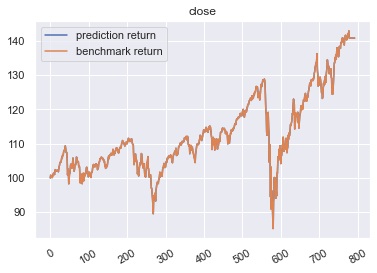

In [23]:
import matplotlib.pyplot as plt # usual module for plotting things
import seaborn as sns

sns.set_theme()

plt.title(target_columns[0])
plt.plot(sim_model, label='prediction return')
plt.plot(sim_benchmark, label='benchmark return')
plt.xticks(rotation=30)
plt.legend()
plt.show()